In [1]:
import pandas as pd
import gurobipy as gp
import math
import pickle as pkl
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 

In [2]:
product_type = "ambient"
num_time_periods = 7

article_data = pd.read_csv("./data/article.csv")
# article_data = article_data[(article_data['TEMPERATURE_ZONE'] == product_type)]

articles = article_data['ARTICLE_ID'].to_list()

forecast_data = pd.read_csv('./data/sales_'+str(num_time_periods)+'.csv')
# forecast_data = forecast_data[forecast_data['ARTICLE_ID'].isin(articles)]

In [3]:
df = article_data [article_data['MEAN_SHELF_LIFE'] <= 7 ]

In [4]:
df.count()

ARTICLE_ID                   1600
TEMPERATURE_ZONE             1600
CATEGORY_LEVEL_1             1600
CATEGORY_LEVEL_2             1600
VOLUME_M3_PER_CU             1600
MEAN_SHELF_LIFE              1600
CU_PER_TU                    1600
ORDERING_COST_FIXED          1600
ORDERING_COST_PER_TU         1600
SALES_MARGIN_PER_CU          1600
CLEARING_COST_PER_CU         1600
MINIMUM_ORDER_QUANTITY_TU    1600
MAXIMUM_ORDER_QUANTITY_TU       0
dtype: int64

In [22]:
article_data[article_data['MEAN_SHELF_LIFE'] == 1 ].count()

ARTICLE_ID                   13
TEMPERATURE_ZONE             13
CATEGORY_LEVEL_1             13
CATEGORY_LEVEL_2             13
VOLUME_M3_PER_CU             13
MEAN_SHELF_LIFE              13
CU_PER_TU                    13
ORDERING_COST_FIXED          13
ORDERING_COST_PER_TU         13
SALES_MARGIN_PER_CU          13
CLEARING_COST_PER_CU         13
MINIMUM_ORDER_QUANTITY_TU    13
MAXIMUM_ORDER_QUANTITY_TU     0
dtype: int64

In [23]:
df.count()

ARTICLE_ID                   1600
TEMPERATURE_ZONE             1600
CATEGORY_LEVEL_1             1600
CATEGORY_LEVEL_2             1600
VOLUME_M3_PER_CU             1600
MEAN_SHELF_LIFE              1600
CU_PER_TU                    1600
ORDERING_COST_FIXED          1600
ORDERING_COST_PER_TU         1600
SALES_MARGIN_PER_CU          1600
CLEARING_COST_PER_CU         1600
MINIMUM_ORDER_QUANTITY_TU    1600
MAXIMUM_ORDER_QUANTITY_TU       0
dtype: int64

In [24]:
articles_short = df['ARTICLE_ID'].to_list()
forecast_data_short = forecast_data[forecast_data['ARTICLE_ID'].isin(articles_short)]


In [25]:
v = forecast_data_short.groupby(['ARTICLE_ID', 'DATE']).agg(cum_sum = ('PICKING_QUANTITY_CU', 'sum'))
v = v.sort_values('cum_sum', ascending = False)

In [26]:
v.groupby(['DATE']).agg(cum_sum= ('cum_sum', 'sum'))


,cum_sum
DATE,
2022-07-11,50452
2022-07-12,39243
2022-07-13,35727
2022-07-14,47255
2022-07-15,48162
2022-07-16,21914


In [27]:
forecast_data.groupby(['DATE']).agg(cum_sum = ('PICKING_QUANTITY_CU', 'sum'))
#p = p.sort_values('cum_sum', ascending = False)

,cum_sum
DATE,
2022-07-11,141430
2022-07-12,110665
2022-07-13,103058
2022-07-14,127348
2022-07-15,130147
2022-07-16,60505


In [28]:
h = forecast_data.groupby(['ARTICLE_ID']).agg(cum_sum = ('PICKING_QUANTITY_CU', 'sum')).sort_values('cum_sum', ascending = False)


In [29]:
h[h['cum_sum'] < 10].count()

cum_sum    1087
dtype: int64

In [30]:
forecast_data['DATE'] = pd.to_datetime(forecast_data['DATE'])
forecast_data['DATE1'] = forecast_data['DATE']

forecast_data.set_index('DATE', inplace=True)

start_date = '2022-03-07'
end_date = '2022-03-13'

filtered_data = forecast_data.loc[start_date:end_date]
order_data_weekly = filtered_data.groupby([pd.Grouper(key='DATE1', freq='W-MON')])


# most_frequent_days = []
# most_frequent_item_per_week = []

# for week, week_data in order_data_weekly:
#     day_counts = week_data['DATE1'].dt.day_name().value_counts()
#     max_frequency = day_counts.max() 

#     item_counts = week_data['ARTICLE_ID'].value_counts()
#     most_frequent_items = item_counts[item_counts == item_counts.max()].index.tolist()  

#     most_frequent_item_per_week.append((week, most_frequent_items, max_frequency))
#     most_frequent_days.append((max_frequency))


/var/folders/_4/_8hnn24n6yx_c_19_rwbfxvc0000gn/T/ipykernel_31109/904589357.py:9: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  filtered_data = forecast_data.loc[start_date:end_date]


In [31]:
order_data_weekly

In [32]:
weekly_counts = filtered_data.groupby(pd.Grouper(freq='W'))['ARTICLE_ID'].apply(lambda x: x.value_counts().loc[x.value_counts() == x.value_counts().max()].index.tolist())

# Print the most frequently ordered items for each week
print(weekly_counts)

Series([], Freq: W-SUN, Name: ARTICLE_ID, dtype: object)


/var/folders/_4/_8hnn24n6yx_c_19_rwbfxvc0000gn/T/ipykernel_31109/1699614009.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  weekly_counts = filtered_data.groupby(pd.Grouper(freq='W'))['ARTICLE_ID'].apply(lambda x: x.value_counts().loc[x.value_counts() == x.value_counts().max()].index.tolist())


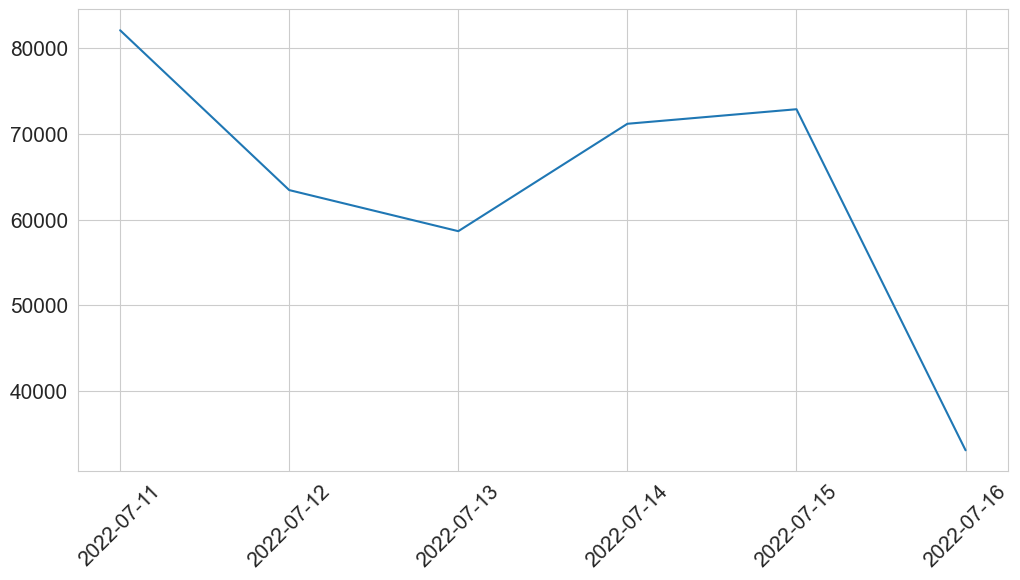

In [36]:
product_type = "ambient"
num_time_periods = 7

# Assuming your DataFrame is already loaded into 'df'
article_data = pd.read_csv("./data/article.csv")
article_data = article_data[(article_data['TEMPERATURE_ZONE'] == product_type)]
articles = article_data['ARTICLE_ID'].to_list()

forecast_data = pd.read_csv('./data/sales_'+str(num_time_periods)+'.csv')
forecast_data = forecast_data[forecast_data['ARTICLE_ID'].isin(articles)]

# Convert the 'date' column to a datetime data type
forecast_data['DATE'] = pd.to_datetime(forecast_data['DATE'])
#forecast_data['day_of_week'] = forecast_data['DATE'].dt.day_name()

forecast_data.set_index('DATE', inplace=True)

# start_date = '2022-02-01'
# end_date = '2022-06-01'

# filtered = forecast_data.loc[start_date:end_date]


daily_demand = forecast_data['PICKING_QUANTITY_CU'].resample('D').sum()

# # Plot the daily demand totals
fig, ax = plt.subplots(figsize=(12, 6))

#
ax.plot(daily_demand.index, daily_demand.values)
# ax.set(xlabel='Date', ylabel='Demand', title='Daily Demand Totals')

plt.xticks(rotation=45)
plt.show()


